<a href="https://colab.research.google.com/github/ZborAl10/Neural-Networks/blob/main/WineNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True #воспроизводимость

In [3]:
import sklearn.datasets
wine = sklearn.datasets.load_wine()
wine.data.shape

(178, 13)

In [4]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    wine.data[:, :2], #возьмем 2 колонки
    wine.target,
    test_size = 0.3, #30% идет в test
    shuffle = True
)

x_train = torch.FloatTensor(x_train)
x_test = torch.FloatTensor(x_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

In [19]:
class WineNet(torch.nn.Module):
  def __init__(self, n_hidden_neurons):
    super(WineNet, self).__init__()
    self.fc1 = torch.nn.Linear(2, n_hidden_neurons)
    self.act1 = torch.nn.Tanh()
    #self.fc2 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons)
    #self.act2 = torch.nn.Sigmoid()
    self.fc3 = torch.nn.Linear(n_hidden_neurons, 3)
    self.sm = torch.nn.Softmax(dim=1)

  def forward(self, x):
    x = self.fc1(x)
    x = self.act1(x)
    #x = self.fc2(x)
    #x = self.act2(x)
    x = self.fc3(x)
    return x

  def inference(self, x): # для подсчёта вероятностей
    x = self.forward(x)
    x = self.sm(x)
    return x

wine_net = WineNet(5)

In [20]:
loss = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(wine_net.parameters(), lr=1.0e-3)

In [7]:
np.random.permutation(5) # перемешивает индексы датасета

array([2, 0, 1, 4, 3])

In [24]:
batch_size = 10

for epoch in range(10000):
  order = np.random.permutation(len(x_train)) # массив перемешанных индексов
  for start_index in range(0, len(x_train), batch_size):
    optimizer.zero_grad()

    # берем из перемешанных индексов часть, определяемую batch_size
    batch_indexes = order[start_index:start_index+batch_size]

    # получаем "батчи" от train datasets
    x_batch = x_train[batch_indexes]
    y_batch = y_train[batch_indexes]

    # без softmax, выходы на 3 нейронах
    preds = wine_net.forward(x_batch)

    # посчитаем loss-функцию...
    loss_val = loss(preds, y_batch)
    loss_val.backward() # ...и ее производную (градиент)

    # шаг градиентного спуска
    optimizer.step()

    # каждые 100 эпох вычисляем метрики, чтобы проверить, обучается ли нейросеть
    if epoch % 100 == 0:
      test_preds = wine_net.forward(x_test)
      test_preds = test_preds.argmax(dim=1)
      print((test_preds == y_test).float().mean())



tensor(0.8704)
tensor(0.8889)
tensor(0.8889)
tensor(0.9074)
tensor(0.8889)
tensor(0.8889)
tensor(0.8889)
tensor(0.8889)
tensor(0.8889)
tensor(0.8889)
tensor(0.8889)
tensor(0.8889)
tensor(0.8889)
tensor(0.8519)
tensor(0.8519)
tensor(0.8333)
tensor(0.8333)
tensor(0.8148)
tensor(0.8148)
tensor(0.8333)
tensor(0.8333)
tensor(0.8333)
tensor(0.8333)
tensor(0.8333)
tensor(0.8519)
tensor(0.8519)
tensor(0.8889)
tensor(0.8889)
tensor(0.8889)
tensor(0.8889)
tensor(0.8889)
tensor(0.8889)
tensor(0.8889)
tensor(0.8889)
tensor(0.8889)
tensor(0.8889)
tensor(0.8889)
tensor(0.8889)
tensor(0.8889)
tensor(0.8889)
tensor(0.8889)
tensor(0.8889)
tensor(0.8889)
tensor(0.8889)
tensor(0.8889)
tensor(0.8704)
tensor(0.8704)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8704)
tensor(0.8704)
tensor(0.8704)
tensor(0.8889)
tensor(0.8889)
tensor(0.8889)
tensor(0.8889)
tensor(0.8704)
tensor(0.8704)
tensor(0.8704)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8889)
tensor(0.8

KeyboardInterrupt: ignored

<ipython-input-25-78c6d92a3c65>:24: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x_train[indexes, 0],


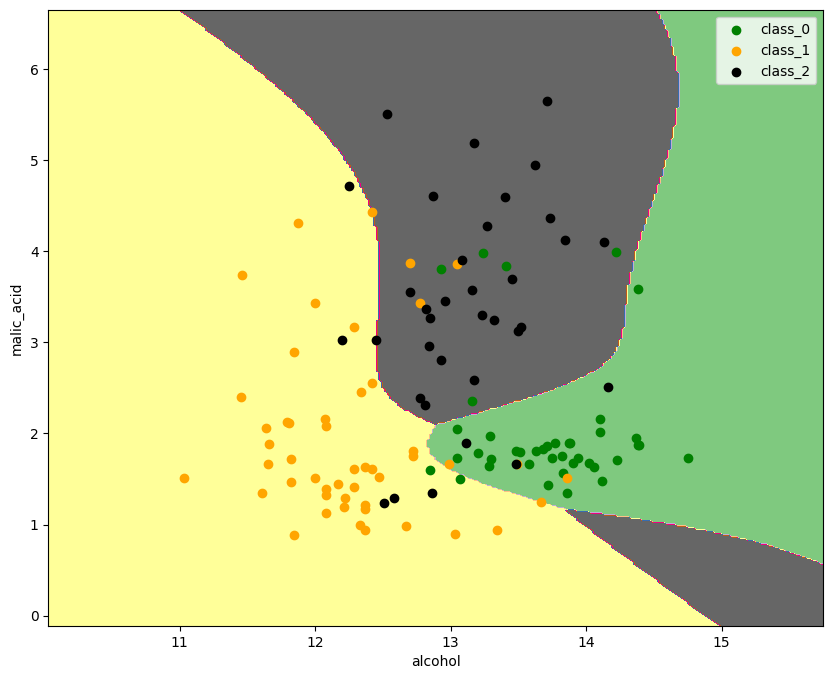

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (10, 8)

n_classes = 3
plot_colors = ['green', 'orange', 'black']
plot_step = 0.02

x_min, x_max = x_train[:, 0].min()-1, x_train[:, 0].max()+1
y_min, y_max = x_train[:, 1].min()-1, x_train[:, 1].max()+1

xx, yy = torch.meshgrid(torch.arange(x_min, x_max, plot_step),
                        torch.arange(y_min, y_max, plot_step))

preds = wine_net.inference(torch.cat([xx.reshape(-1, 1), yy.reshape(-1, 1)], dim=1))

preds_class = preds.data.numpy().argmax(axis=1)
preds_class = preds_class.reshape(xx.shape)
plt.contourf(xx, yy, preds_class, cmap='Accent')

for i, color in enumerate(plot_colors):
  indexes = np.where(y_train == i)
  plt.scatter(x_train[indexes, 0],
              x_train[indexes, 1],
              c=color,
              label=wine.target_names[i],
              cmap='Accent')
  plt.xlabel(wine.feature_names[0])
  plt.ylabel(wine.feature_names[1])
  plt.legend()